## 3. Extrapolation Test

Train on [-2,1] and test on [1,2] to evaluate extrapolation capabilities.

In [39]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Import implementations
from kan import KAN as PyKAN
from efficient_kan import KAN as EfficientKAN
from kan.MLP import MLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

In [40]:
def train_model(model, dataset, steps=50):
    if isinstance(model, MLP):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        train_losses = []
        test_losses = []
        
        for i in tqdm(range(steps)):
            for _ in range(100):
                optimizer.zero_grad()
                y_pred = model(dataset['train_input'])
                loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                train_loss = nn.functional.mse_loss(
                    model(dataset['train_input']), 
                    dataset['train_label']
                )
                test_loss = nn.functional.mse_loss(
                    model(dataset['test_input']), 
                    dataset['test_label']
                )
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
    else:
        # Original LBFGS code for other models
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
        model = model.to(device)
        
        train_losses = []
        test_losses = []
        
        for i in tqdm(range(steps)):
            def closure():
                optimizer.zero_grad()
                y_pred = model(dataset['train_input'])
                loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
                loss.backward()
                return loss
            
            optimizer.step(closure)
            
            with torch.no_grad():
                train_loss = nn.functional.mse_loss(
                    model(dataset['train_input']), 
                    dataset['train_label']
                )
                test_loss = nn.functional.mse_loss(
                    model(dataset['test_input']), 
                    dataset['test_label']
                )
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
                
    return train_losses[-1], test_losses[-1]

def train_pykan(dataset, grid_size):
    model = PyKAN(width=[2,5,1], grid=grid_size, k=3, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50)
    return model, results['train_loss'][-1], results['test_loss'][-1]

In [41]:
def generate_extrapolation_data(n_train=800, n_test=200):
    x_train = torch.linspace(-2, 1, n_train).reshape(-1, 1)
    y_train = torch.sin(np.pi * x_train)
    
    x_test = torch.linspace(1, 2, n_test).reshape(-1, 1)
    y_test = torch.sin(np.pi * x_test)
    
    return {
        'train_input': x_train,
        'train_label': y_train,
        'test_input': x_test,
        'test_label': y_test
    }

dataset = generate_extrapolation_data()

In [42]:
# Fix: Change input dimension to 1
grid_size = 20
pykan_model = PyKAN([1,5,1], grid=grid_size, k=3, device=device)
effkan_model = EfficientKAN([1,5,1], grid_size=grid_size, spline_order=3)
mlp_model = MLP([1,5,1])

pykan_results = pykan_model.fit(dataset)
effkan_train_loss, effkan_test_loss = train_model(effkan_model, dataset)
mlp_train_loss, mlp_test_loss = train_model(mlp_model, dataset)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-03 | test_loss: 1.23e+00 | reg: 1.24e+01 | : 100%|█| 100/100 [00:07<00:00, 13.76


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 38.06it/s]


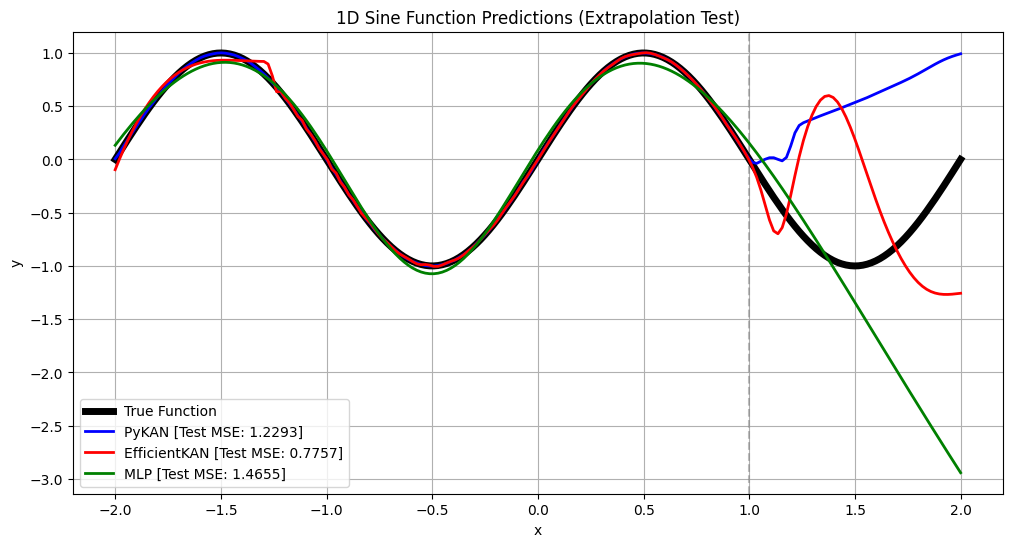

In [43]:
# 3. Extrapolation Test Visualization
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)
with torch.no_grad():
    pykan_preds = pykan_model(x_fine)
    effkan_preds = effkan_model(x_fine)
    mlp_preds = mlp_model(x_fine)
    true_vals = torch.sin(np.pi * x_fine)

plt.figure(figsize=(12, 6))
plt.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=5)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN [Test MSE: {pykan_results["test_loss"][-1]:.4f}]', linewidth=2)
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN [Test MSE: {effkan_test_loss:.4f}]', linewidth=2)
plt.plot(x_fine, mlp_preds, 'g-',
        label=f'MLP [Test MSE: {mlp_test_loss:.4f}]', linewidth=2)
plt.title('1D Sine Function Predictions (Extrapolation Test)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

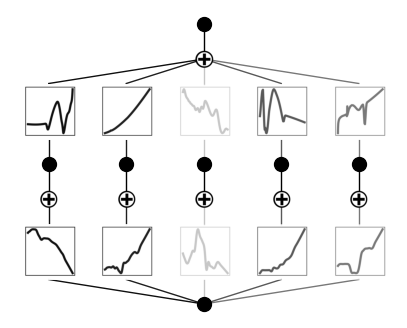

In [44]:
pykan_model.plot()

In [45]:
# First make the model symbolic
pykan_model.auto_symbolic()

# Then get and display the symbolic formula 
from kan.utils import ex_round
formula = ex_round(pykan_model.symbolic_formula()[0][0], 4)
formula

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,0,4) with 0, r2=0.0, c=0
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,1,0) with cos, r2=0.9999297857284546, c=2
fixing (1,2,0) with 0, r2=0.0, c=0
fixing (1,3,0) with 0, r2=0.0, c=0
fixing (1,4,0) with 0, r2=0.0, c=0
saving model version 0.2


0.2323